In [54]:
import pandas as pd

In [146]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Отображение графика

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

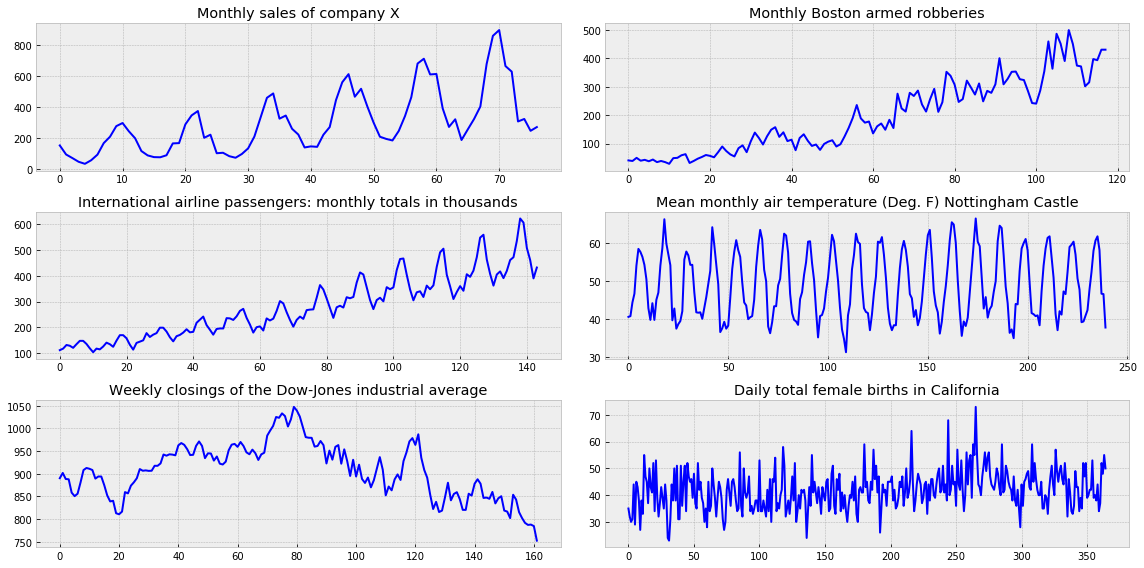

In [148]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Ищем сезонность

In [149]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

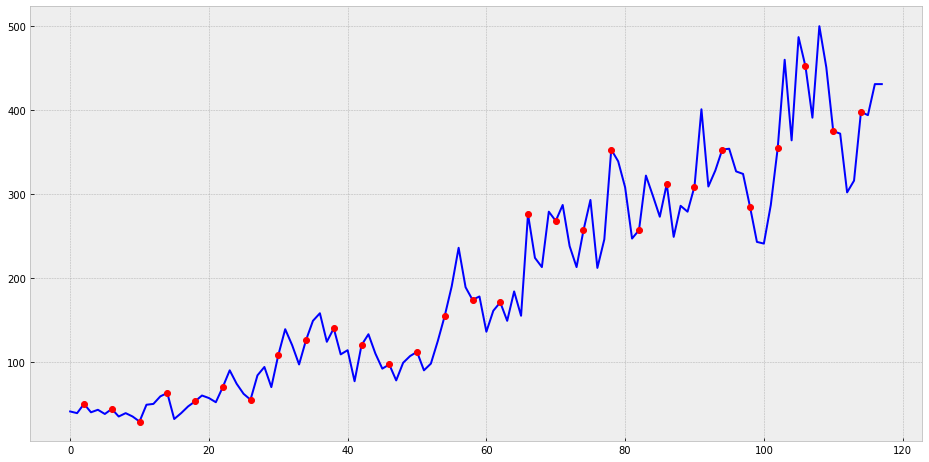

In [60]:
plot_ts_and_points(robberies_in_boston['Count'], 2, 4)

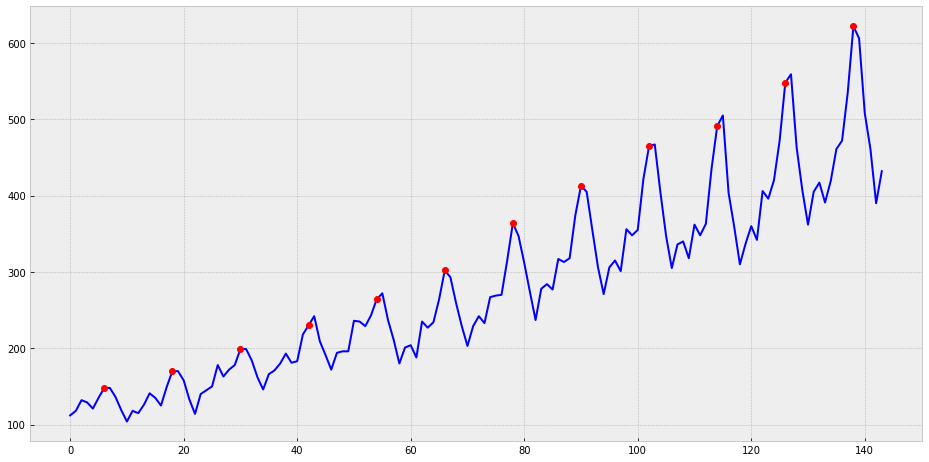

In [61]:
plot_ts_and_points(airlines_passengers['Count'], 6, 12)

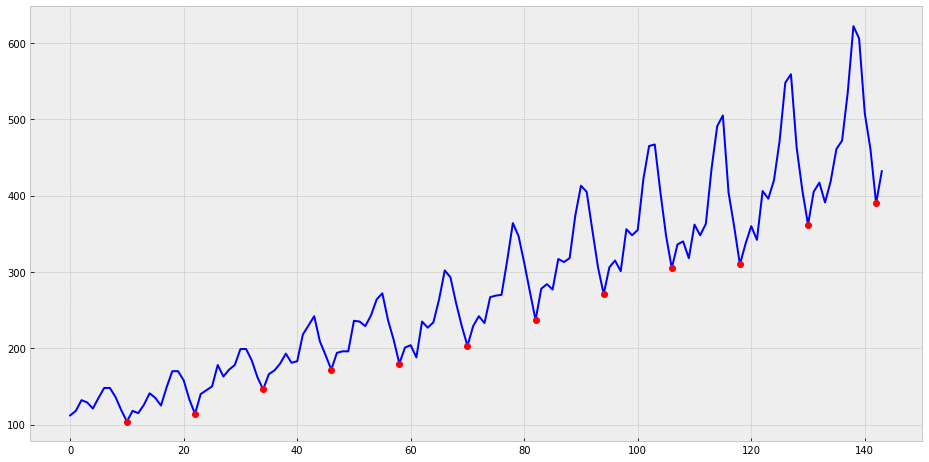

In [62]:
plot_ts_and_points(airlines_passengers['Count'], 10, 12)

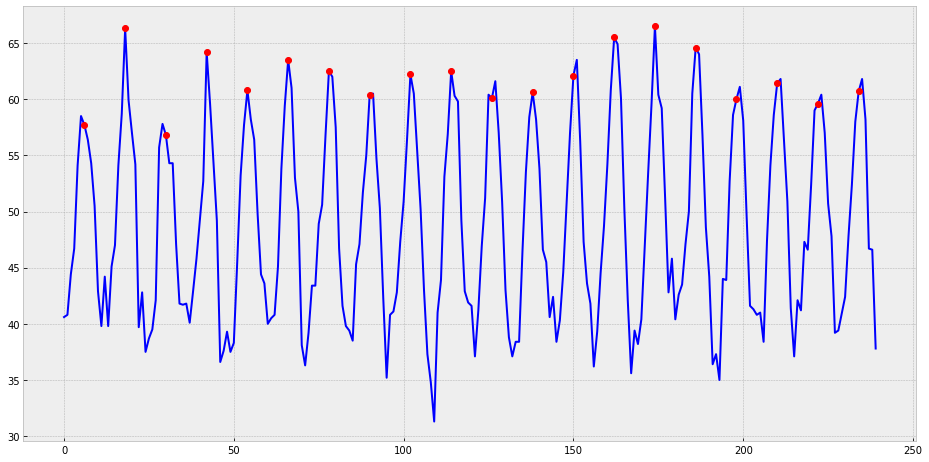

In [63]:
plot_ts_and_points(mean_monthly_temp['Deg'], 6, 12)

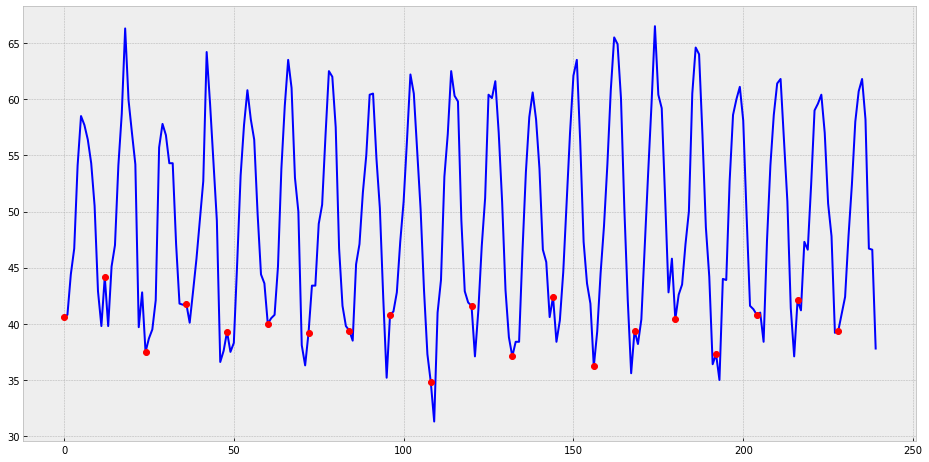

In [64]:
plot_ts_and_points(mean_monthly_temp['Deg'], 0, 12)

In [65]:
results = []

for i in range(36):
    results.append((i+1, airlines_passengers['Count'].autocorr(i+1)))
    print(i, results[-1][1])

0 0.9601946480498523
1 0.8956753113926396
2 0.837394765081794
3 0.7977346989350624
4 0.7859431491184304
5 0.7839187959206183
6 0.7845921291388301
7 0.7922150472595747
8 0.8278519011167601
9 0.8827127951607838
10 0.9497020331006317
11 0.990527369208544
12 0.9481066160592018
13 0.8754477915539788
14 0.8114659384543109
15 0.7694487920842656
16 0.7558191230371455
17 0.7487523142605247
18 0.7455000168641182
19 0.7517886585378154
20 0.7945029068579574
21 0.8590126910996432
22 0.9367167085350967
23 0.9832540581084245
24 0.9383950396641393
25 0.8587791866104537
26 0.7896553675595263
27 0.7450836286630406
28 0.7291761264062386
29 0.7220983300919573
30 0.7182650317862975
31 0.7246675702801956
32 0.77010398814767
33 0.8422110826816892
34 0.9248247848432761
35 0.9772832036352762


# Нормализуем дисперсию

In [118]:
from scipy.stats import boxcox

In [119]:
series = boxcox(all_series["International airline passengers: monthly totals in thousands"], 0)

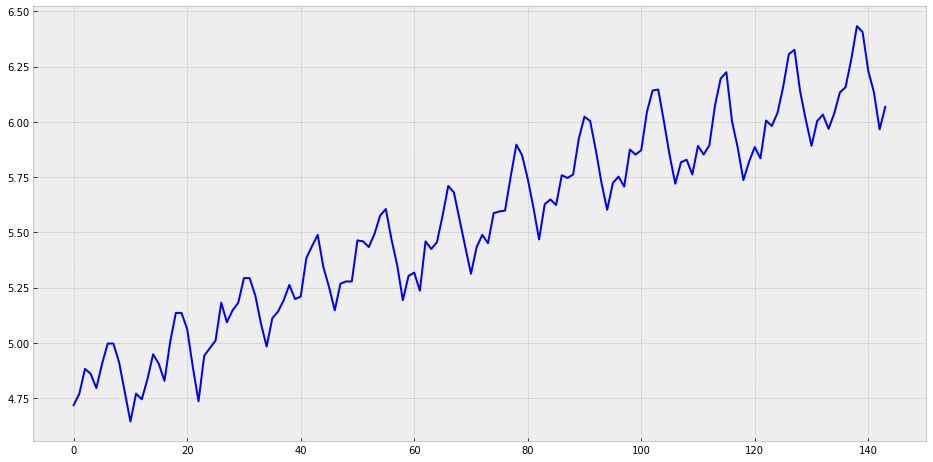

In [120]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

# Дифференцируем 

In [121]:
import numpy as np

In [122]:
series = np.diff(series, 1)

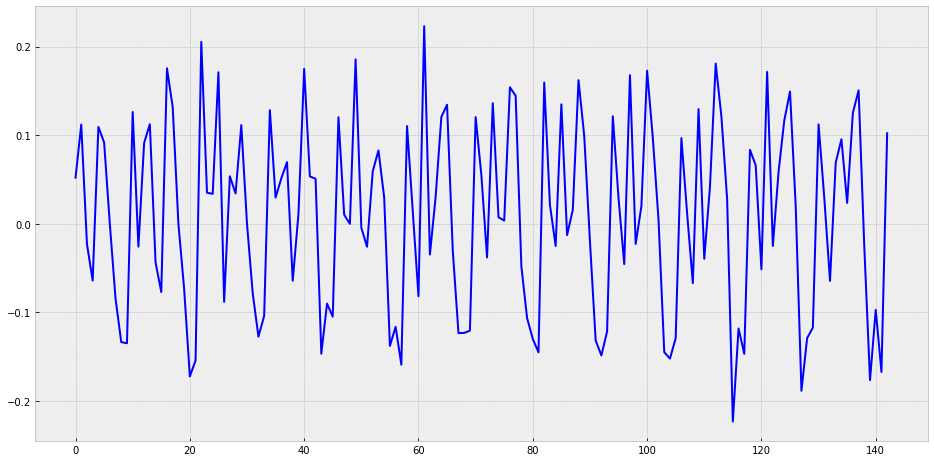

In [123]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

# Тест Дики-Фуллера 

In [124]:
from statsmodels.tsa.stattools import adfuller

In [125]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [126]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [127]:
test_stationarity(all_series["International airline passengers: monthly totals in thousands"])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# Коррелограммы

In [128]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [129]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


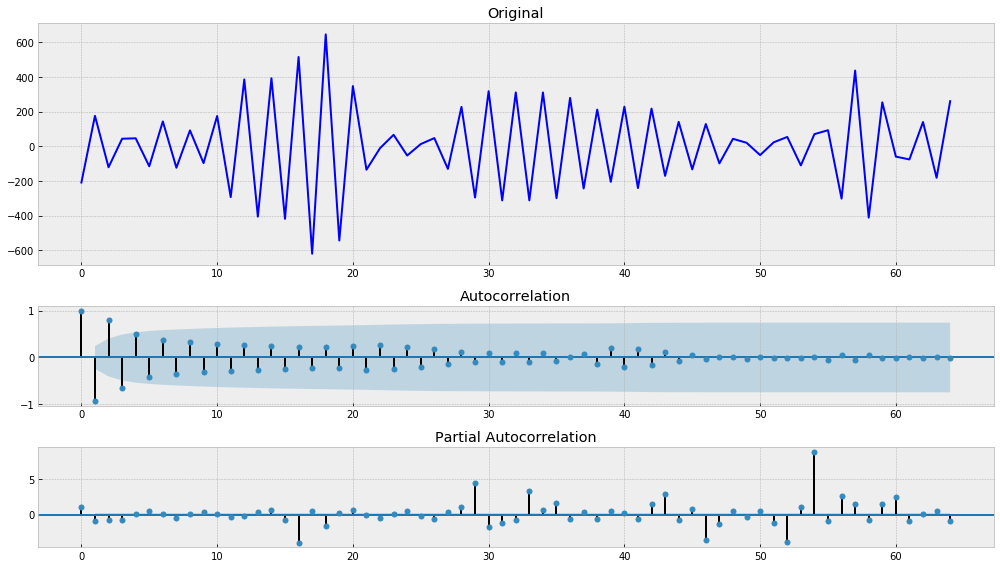

In [112]:
tsplot(series)

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


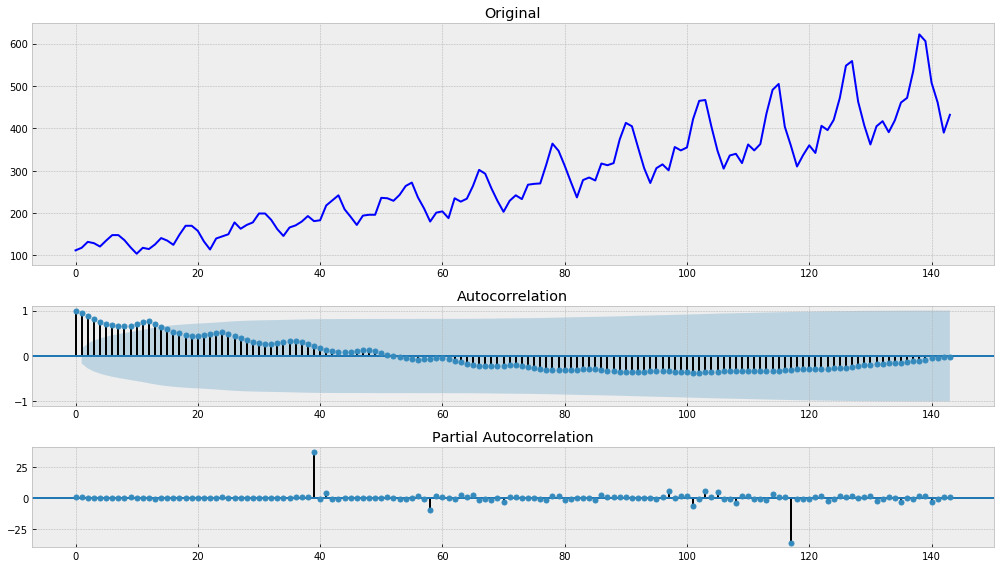

In [108]:
tsplot(all_series["International airline passengers: monthly totals in thousands"])

Monthly sales of company X

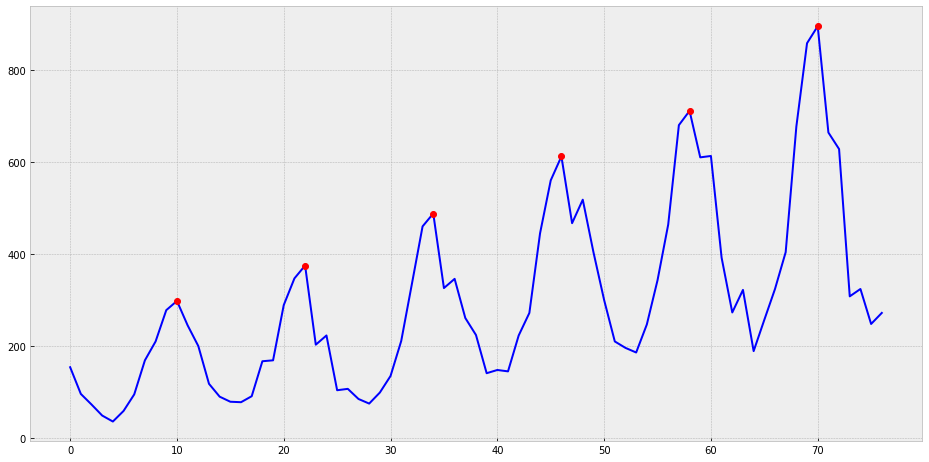

In [150]:
plot_ts_and_points(sales_of_company_x["Count"], 10, 12)

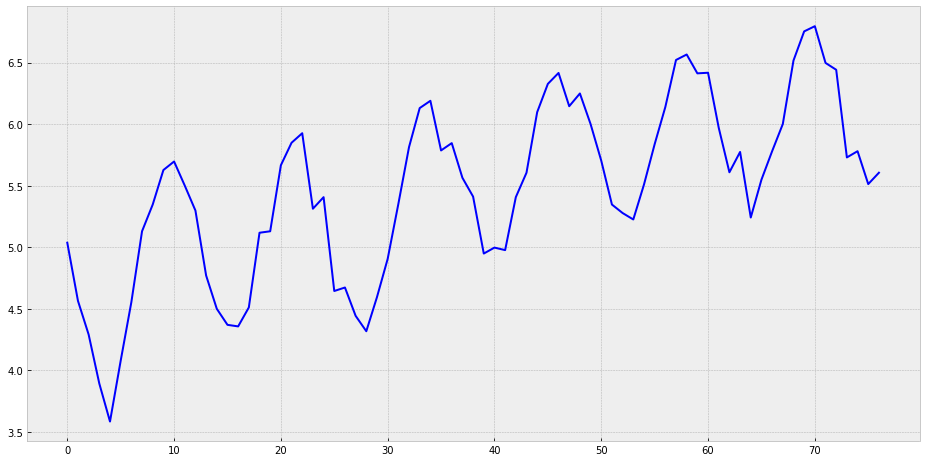

In [152]:
# уменьшаем дисперсию Боксом-Коксом
series = boxcox(all_series["Monthly sales of company X"], 0)
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

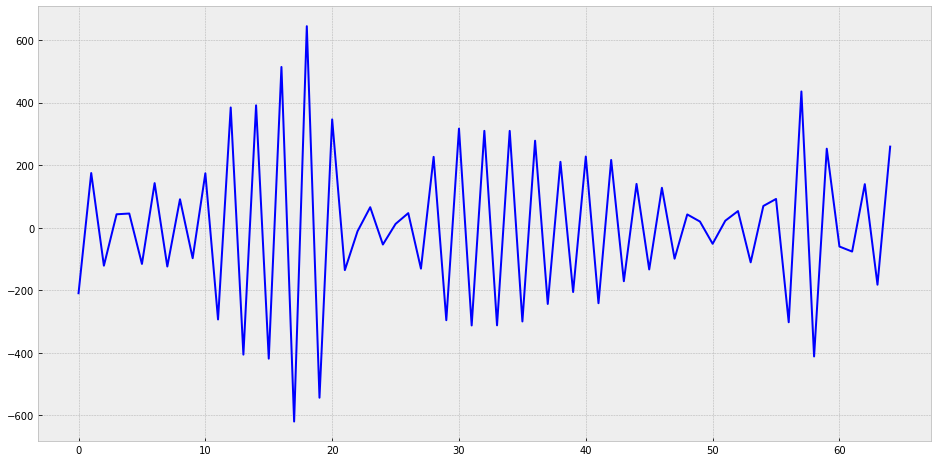

In [153]:
# дифференцируем
series = np.diff(series, 12)
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

In [154]:
# гипотезу о нестационарности отвергаем из-за p-value < 0.05
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.633549e+00
p-value                        1.979614e-11
#Lags Used                     1.100000e+01
Number of Observations Used    5.300000e+01
Critical Value (1%)           -3.560242e+00
Critical Value (5%)           -2.917850e+00
Critical Value (10%)          -2.596796e+00
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


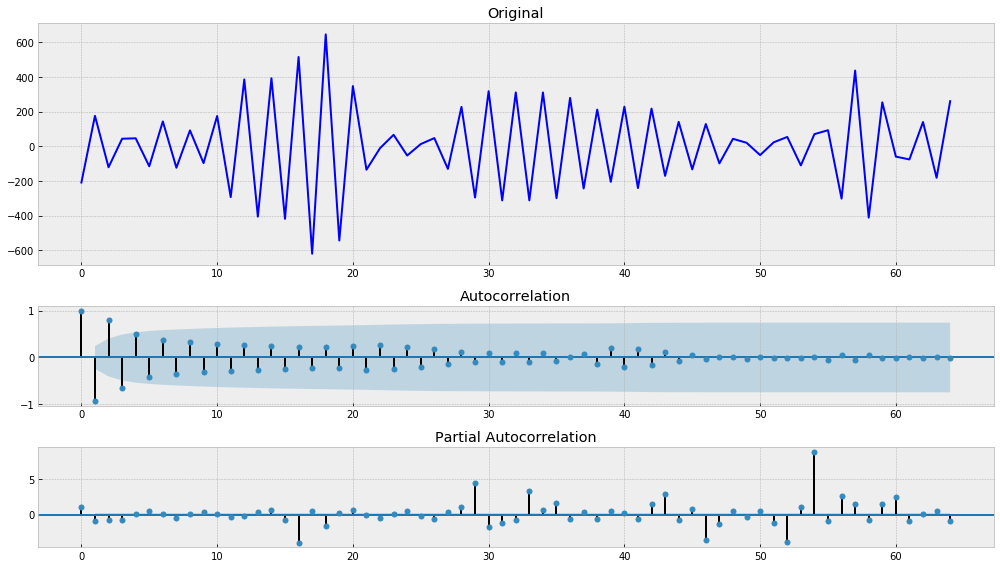

In [145]:
# коррелограммы
tsplot(series)